## Notebook Overview

In this notebook, we perform an Exploratory Data Analysis on a dataset that classifies patients in the ICU that will develop Sepsis and those that will not develop Sepsis

# Set Up

## Installation

Here is the section where we installed all the packages/libraries that will be needed to tackle the challlenge.

In [1]:
# Installing of packages
%%capture
!pip install numpy
!pip install pandas
!pip install patool
!pip install forex_python
!pip install pandas_profiling
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install -U imbalanced-learn

# Importation

Here is the section to import all the packages/libraries that will be used through this notebook.

In [2]:
# Data handling
import pandas as pd
import numpy as np
import threadpoolctl

# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import seaborn as sns
import seaborn as sn
import matplotlib.pyplot as plt

# EDA (pandas-profiling, etc. )

# Statistics
from scipy import stats
from scipy.stats import shapiro, trim_mean, mstats, mode, ttest_ind

# Feature Processing (Scikit-learn processing, etc. )
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Balance data
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Evaluations
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from statistics import stdev
from sklearn.model_selection import KFold

# Other packages
import os, pickle

import warnings
warnings.filterwarnings("ignore")

# Data Loading

Here is the section to load the datasets (train, eval, test) and the additional files

In [3]:
url = 'https://raw.githubusercontent.com/Herb-real/Sepsis-Prediction-ML-and-FastAPI/main/assets/data/Paitients_Files_Train.csv'
train_df = pd.read_csv(url)

url2 = 'https://raw.githubusercontent.com/Herb-real/Sepsis-Prediction-ML-and-FastAPI/main/assets/data/Paitients_Files_Test.csv'
test_df = pd.read_csv(url2)

# Dataset overview

Have a look at the loaded datsets using the following methods: .head(), .info()

In [4]:
# A quick look at the shape of our dataset

train_df.shape

(599, 11)

In [5]:
#Looking at the head of our dataset

train_df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [6]:
#Taking a look at the tail
train_df.tail()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
594,ICU200604,6,123,72,45,230,33.6,0.733,34,0,Negative
595,ICU200605,0,188,82,14,185,32.0,0.682,22,1,Positive
596,ICU200606,0,67,76,0,0,45.3,0.194,46,1,Negative
597,ICU200607,1,89,24,19,25,27.8,0.559,21,0,Negative
598,ICU200608,1,173,74,0,0,36.8,0.088,38,1,Positive


Columns Description

ID - Unique number to represent patient ID

PRG - Plasma glucose

PL - Blood Work Result-1 (mu U/ml)

PR - Blood Pressure (mm Hg)

SK - Blood Work Result-2 (mm)

TS - Blood Work Result-3 (mu U/ml)

M11 - Body mass index (weight in kg/(height in m)^2

BD2 - Blood Work Result-4 (mu U/ml)

Age - patients age (years)

Insurance - If a patient holds a valid insurance card

Sepssis Target Positive: if a patient in ICU will develop a sepsis , and Negative: otherwise

In [7]:
#Look at the columns in the dataset and their data types

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


In [8]:
#Get more details about the features of our data
train_df.describe()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,3.824708,120.153589,68.732888,20.562604,79.460768,31.920033,0.481187,33.290484,0.686144
std,3.362839,32.682364,19.335675,16.017622,116.576176,8.008227,0.337552,11.828446,0.464447
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.100000,0.248000,24.000000,0.000000
50%,3.000000,116.000000,70.000000,23.000000,36.000000,32.000000,0.383000,29.000000,1.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [9]:
#Check for missing values
train_df.isna().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepssis      0
dtype: int64

<Axes: >

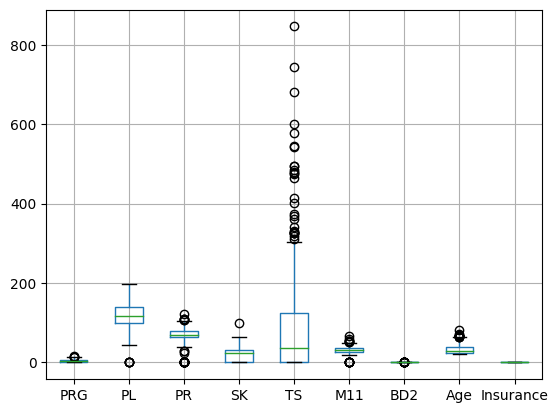

In [10]:
#Check for outliers
train_df.boxplot()

# Issues With the Data

Too many zeros in each column

The column names are not very descriptive.

The target variable 'Sepssis' may have imbalanced classes.

There are many outliers in some of the numerical columns.

There could be correlations between some of the predictor variables, leading to multicollinearity.

# How I Intend to Solve Them

Replace zeros in each column with the median value

Rename the column names to be more descriptive and easier to understand.

Handle the imbalanced classes in the target variable using techniques such as undersampling or oversampling.

Use visualization techniques such as box plots and scatter plots to identify outliers and then remove them.

Use correlation analysis to identify highly correlated variables and consider dropping or transforming them.

# Hypothesis

**Null Hypothesis:** Age does not determine whether a patient will develop Sepsis.

**Alternate Hypothesis:** Age determines whether a pateint will develop Sepsis.

# Questions

1. Is the train dataset complete?
2. What are the ages of the youngest and oldest patients?
3. What are the youngest and oldest patients with Sepssis?
4. What is the average age ?
5. What is the ratio of patients who are positive for sepssis to the negative patients ?
6. What is the highest and lowest BMI?
7. What is the average BMI ?
8. Is there a corelation between the Sepssis status and the other attributes?

# Data Cleaning

In [11]:
# First Rename the columns
train_df = train_df.rename(columns={
    "PRG": "Plasma_glucose",
    "PL": "Blood_Work_R1",
    "PR": "Blood_Pressure",
    "SK": "Blood_Work_R2",
    "TS": "Blood_Work_R3",
    "M11": "BMI",
    "BD2": "Blood_Work_R4",
    "Age": "Patient_age",
    "Sepssis": "Target"
})

In [12]:
numerical_features = ['Plasma_glucose', 'Blood_Work_R1', 'Blood_Pressure', 'Blood_Work_R2', 'Blood_Work_R3', 'BMI', 'Blood_Work_R4', 'Patient_age']


Removing the rows where BMI is 0

In [13]:
# Lets inspect our dataset again
train_df

,ID,Plasma_glucose,Blood_Work_R1,Blood_Pressure,Blood_Work_R2,Blood_Work_R3,BMI,Blood_Work_R4,Patient_age,Insurance,Target
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive
...,...,...,...,...,...,...,...,...,...,...,...
594,ICU200604,6,123,72,45,230,33.6,0.733,34,0,Negative
595,ICU200605,0,188,82,14,185,32.0,0.682,22,1,Positive
596,ICU200606,0,67,76,0,0,45.3,0.194,46,1,Negative
597,ICU200607,1,89,24,19,25,27.8,0.559,21,0,Negative


A glance at our dataset shows the value 0 in some of the columns. This can not be possible and indicates the presence of wrong vaules in our dataset. Lets first remove 0 BMIs and replace the other 0 values in the columns with the median.

In [14]:
#Extracting rows with 0 BMI
zero_bmi = train_df[train_df['BMI']==0.0]
zero_bmi

,ID,Plasma_glucose,Blood_Work_R1,Blood_Pressure,Blood_Work_R2,Blood_Work_R3,BMI,Blood_Work_R4,Patient_age,Insurance,Target
9,ICU200019,8,125,96,0,0,0.0,0.232,54,1,Positive
49,ICU200059,7,105,0,0,0,0.0,0.305,24,0,Negative
60,ICU200070,2,84,0,0,0,0.0,0.304,21,0,Negative
81,ICU200091,2,74,0,0,0,0.0,0.102,22,1,Negative
145,ICU200155,0,102,75,23,0,0.0,0.572,21,1,Negative
371,ICU200381,0,118,64,23,89,0.0,1.731,21,1,Negative
426,ICU200436,0,94,0,0,0,0.0,0.256,25,0,Negative
494,ICU200504,3,80,0,0,0,0.0,0.174,22,1,Negative
522,ICU200532,6,114,0,0,0,0.0,0.189,26,1,Negative


In [15]:
# Removing rows with 0 BMI
train_df.drop(train_df[train_df['BMI'] == 0.0].index, inplace=True)

In [16]:
#confirming that all 0 BMIs have been removed from our dataset
zero_bmi2 = train_df[train_df['BMI']==0.0]
zero_bmi2

,ID,Plasma_glucose,Blood_Work_R1,Blood_Pressure,Blood_Work_R2,Blood_Work_R3,BMI,Blood_Work_R4,Patient_age,Insurance,Target


Replace zeros in other columns with the median value

In [17]:
# Another look at our dataset shows that most of our columns have 0 for values.
train_df

,ID,Plasma_glucose,Blood_Work_R1,Blood_Pressure,Blood_Work_R2,Blood_Work_R3,BMI,Blood_Work_R4,Patient_age,Insurance,Target
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive
...,...,...,...,...,...,...,...,...,...,...,...
594,ICU200604,6,123,72,45,230,33.6,0.733,34,0,Negative
595,ICU200605,0,188,82,14,185,32.0,0.682,22,1,Positive
596,ICU200606,0,67,76,0,0,45.3,0.194,46,1,Negative
597,ICU200607,1,89,24,19,25,27.8,0.559,21,0,Negative


In [18]:
columns_with_too_many_zeros = ['Plasma_glucose', 'Blood_Work_R2', 'Blood_Work_R3']
for col in columns_with_too_many_zeros:
    train_df[col].replace(to_replace=0, value=train_df[col].median(), inplace=True)

In [19]:
train_df


,ID,Plasma_glucose,Blood_Work_R1,Blood_Pressure,Blood_Work_R2,Blood_Work_R3,BMI,Blood_Work_R4,Patient_age,Insurance,Target
0,ICU200010,6,148,72,35,39,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,39,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,23,39,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,3,137,40,35,168,43.1,2.288,33,1,Positive
...,...,...,...,...,...,...,...,...,...,...,...
594,ICU200604,6,123,72,45,230,33.6,0.733,34,0,Negative
595,ICU200605,3,188,82,14,185,32.0,0.682,22,1,Positive
596,ICU200606,3,67,76,23,39,45.3,0.194,46,1,Negative
597,ICU200607,1,89,24,19,25,27.8,0.559,21,0,Negative


Checking for Outliers


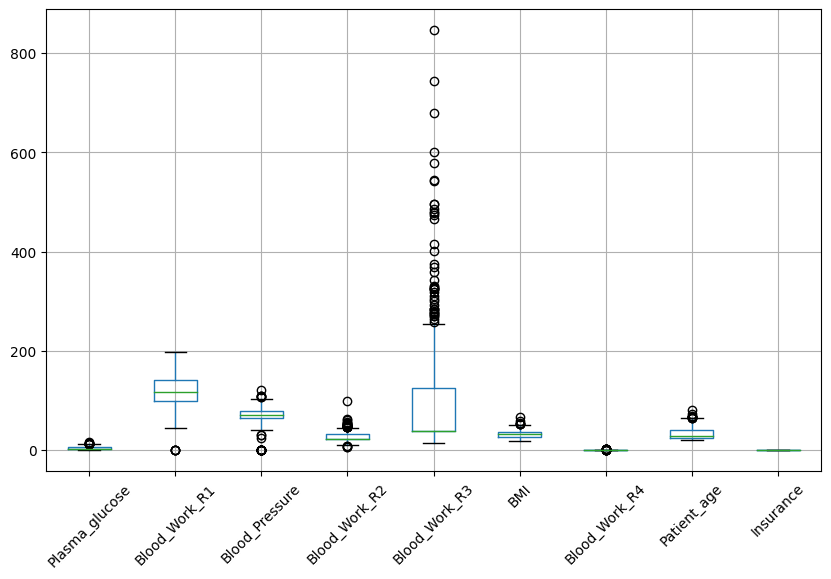

In [20]:
plt.figure(figsize=(10, 6))

# Plot the boxplot
train_df.boxplot()

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Display the plot
plt.show()

The box plots of the various columns as visualized above, shows the presence of outliers in our data. Outliers can skew the results of machine learning models and make them less accurate and reliable.

In [21]:
numeric_columns = train_df.select_dtypes(include=[np.number]).columns
num_df = train_df[numeric_columns]

Q1 = num_df.quantile(0.25)
Q3 = num_df.quantile(0.75)
IQR = Q3-Q1
IQR
((num_df< (Q1-1.5 * IQR)) | (num_df > (Q3 + 1.5 * IQR))).any()

Plasma_glucose     True
Blood_Work_R1      True
Blood_Pressure     True
Blood_Work_R2      True
Blood_Work_R3      True
BMI                True
Blood_Work_R4      True
Patient_age        True
Insurance         False
dtype: bool

All the numeric_columns except Insurance have outliers.

Calculating the Interquartile range, setting the outlier boundary and removing the outliers from the dataframe

In [22]:
# Specify the columns of interest
columns_of_interest =  ['BMI', 'Blood_Pressure', 'Blood_Work_R1','Blood_Work_R2','Blood_Work_R3','Blood_Work_R4','Patient_age','Plasma_glucose']

# Check if outliers still exist in the columns
outliers_exist = False

for column in columns_of_interest:
    # Calculate the first and third quartiles (Q1 and Q3)
    Q1 = train_df[column].quantile(0.25)
    Q3 = train_df[column].quantile(0.75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Modify the values in the column to be within the range
    train_df[column] = train_df[column].clip(lower_bound, upper_bound)

    # Check if outliers exist in the column
    if (train_df[column] < lower_bound).any() or (train_df[column] > upper_bound).any():
        outliers_exist = True
        print(f"Outliers still exist in '{column}'.")

if not outliers_exist:
    print("No outliers exist in the specified columns.")

No outliers exist in the specified columns.


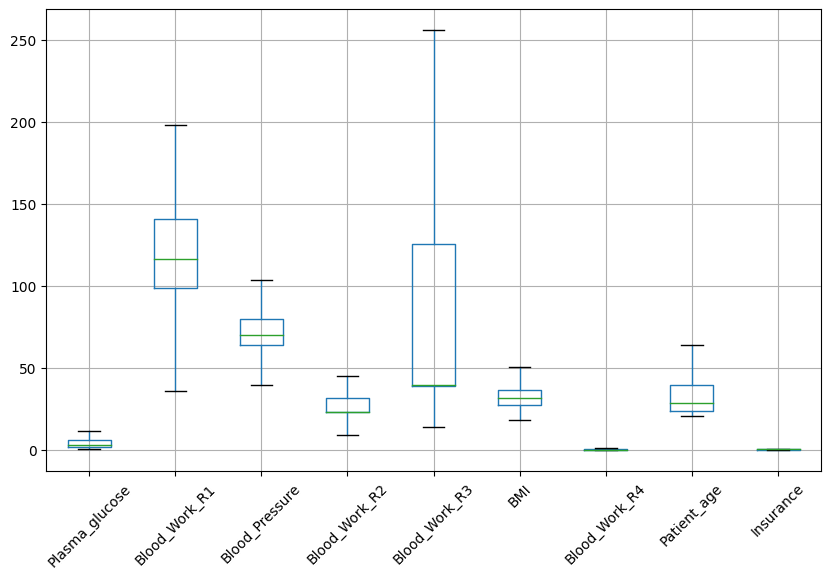

In [23]:
plt.figure(figsize=(10, 6))

# Plot the boxplot
train_df.boxplot()

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Display the plot
plt.show()

We can see from the above that the outliers have been removed

# Univariate Analysis

Graphically Displaying all numerical columns using Histogram

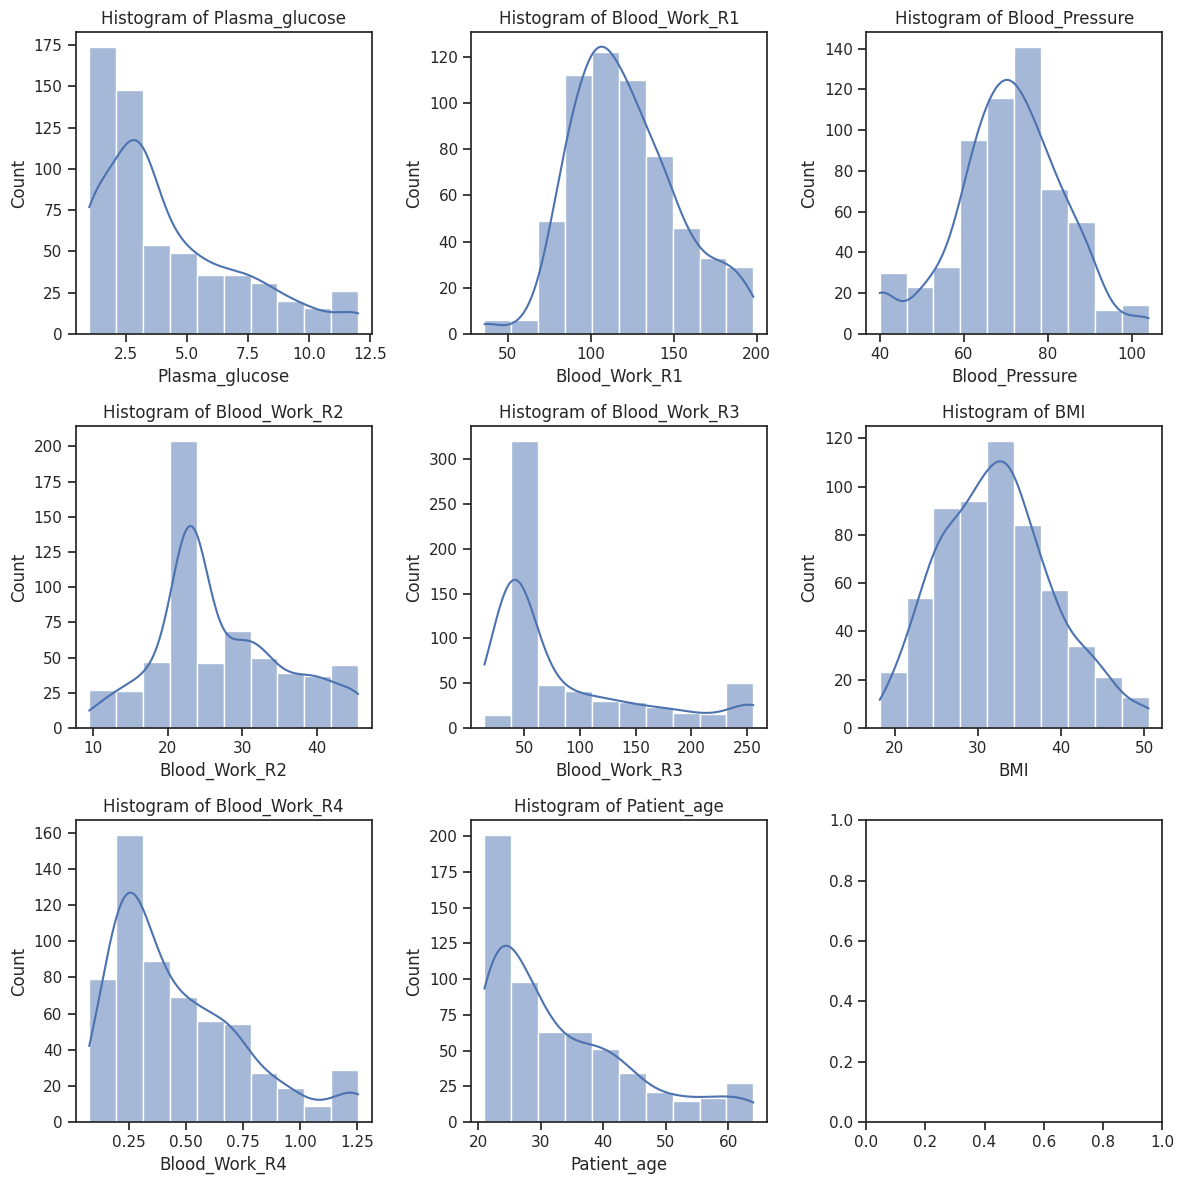

In [24]:
# Set the style for the plot
sn.set(style="ticks", color_codes=True)

# Create a grid of 3 by 3 subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Flatten the axes array
axes = axes.flatten()

# Plot histograms for each numerical column
for i, col in enumerate(numerical_features):
    sn.histplot(data=train_df, x=col, kde=True, bins=10, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

Observations:

Most patients showed up for blood work 1 and 3

Most patients have a blood pressure between 60 and 80

Most patients have glucose level less than five

The majority of patients are younger than 40

# Bivariate Analysis

In [25]:
# get a DataFrame for positive and another for neagtive cases
positive_cases = train_df[train_df['Target'] == 'Positive']
negative_cases = train_df[train_df['Target'] == 'Negative']

Age

In [26]:
positive_age_stats = positive_cases['Patient_age'].describe()
positive_age_stats

count    207.000000
mean      36.589372
std       10.800058
min       21.000000
25%       28.000000
50%       35.000000
75%       43.000000
max       64.000000
Name: Patient_age, dtype: float64

In [27]:
negative_age_stats = negative_cases['Patient_age'].describe()
negative_age_stats

count    383.000000
mean      31.548303
std       11.612285
min       21.000000
25%       23.000000
50%       27.000000
75%       37.000000
max       64.000000
Name: Patient_age, dtype: float64

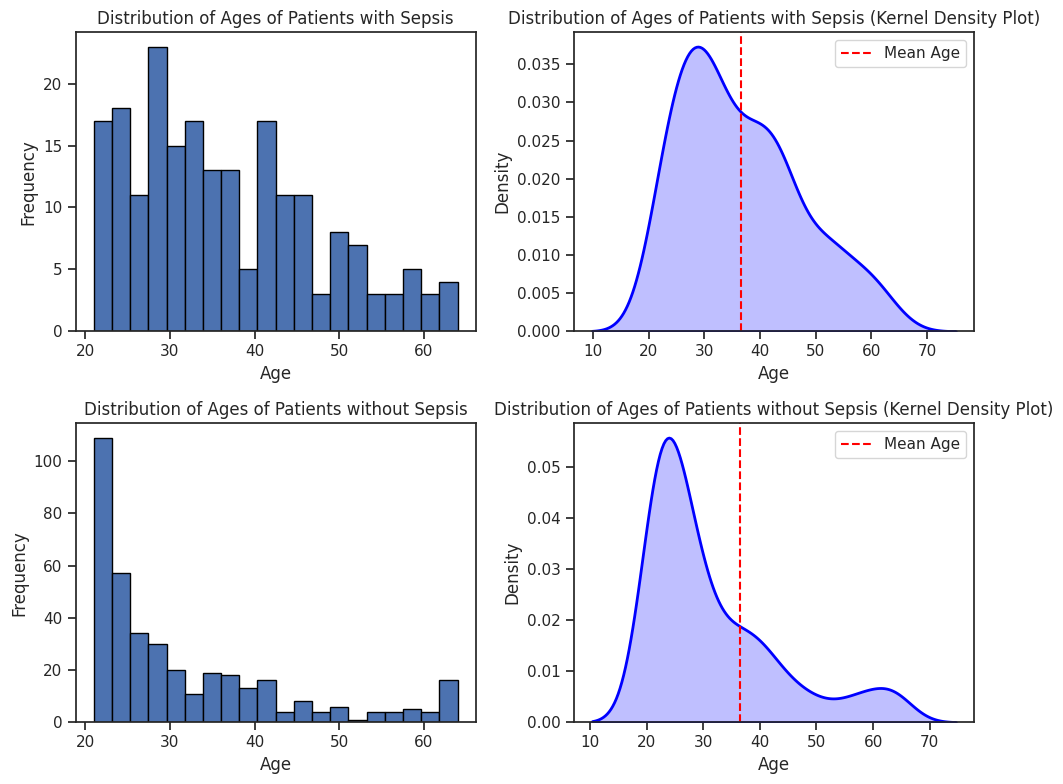

In [28]:
# Extract the 'age' column from the DataFrame
ages_positive = positive_cases['Patient_age']
ages_negative = negative_cases['Patient_age']

positive_mean_age = positive_age_stats['mean']

# Set up the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot 1: Distribution of Ages for Patients with Sepsis
axes[0, 0].hist(ages_positive, bins=20, edgecolor='black')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Ages of Patients with Sepsis')

sns.kdeplot(ages_positive, shade=True, color='blue', linewidth=2, ax=axes[0, 1])
axes[0, 1].axvline(positive_mean_age, color='red', linestyle='--', label='Mean Age')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Distribution of Ages of Patients with Sepsis (Kernel Density Plot)')
axes[0, 1].legend()

# Plot 2: Distribution of Ages for Patients without Sepsis
axes[1, 0].hist(ages_negative, bins=20, edgecolor='black')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Ages of Patients without Sepsis')

sns.kdeplot(ages_negative, shade=True, color='blue', linewidth=2, ax=axes[1, 1])
axes[1, 1].axvline(positive_mean_age, color='red', linestyle='--', label='Mean Age')
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Distribution of Ages of Patients without Sepsis (Kernel Density Plot)')
axes[1, 1].legend()

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

We can observe that younger patients have more cases of Negative sepsis than older ones.

This suggests that our Null Hypothesis(Age does not determine whether a patient will develop Sepsis) is incorrect.

BMI

In [29]:
positive_bmi_stats = positive_cases['BMI'].describe()
positive_bmi_stats

count    207.000000
mean      35.378623
std        6.216960
min       22.900000
25%       31.050000
50%       34.300000
75%       39.050000
max       50.512500
Name: BMI, dtype: float64

In [30]:
negative_bmi_stats = negative_cases['BMI'].describe()
negative_bmi_stats

count    383.000000
mean      30.700033
std        6.540889
min       18.200000
25%       25.450000
50%       30.100000
75%       35.150000
max       50.512500
Name: BMI, dtype: float64

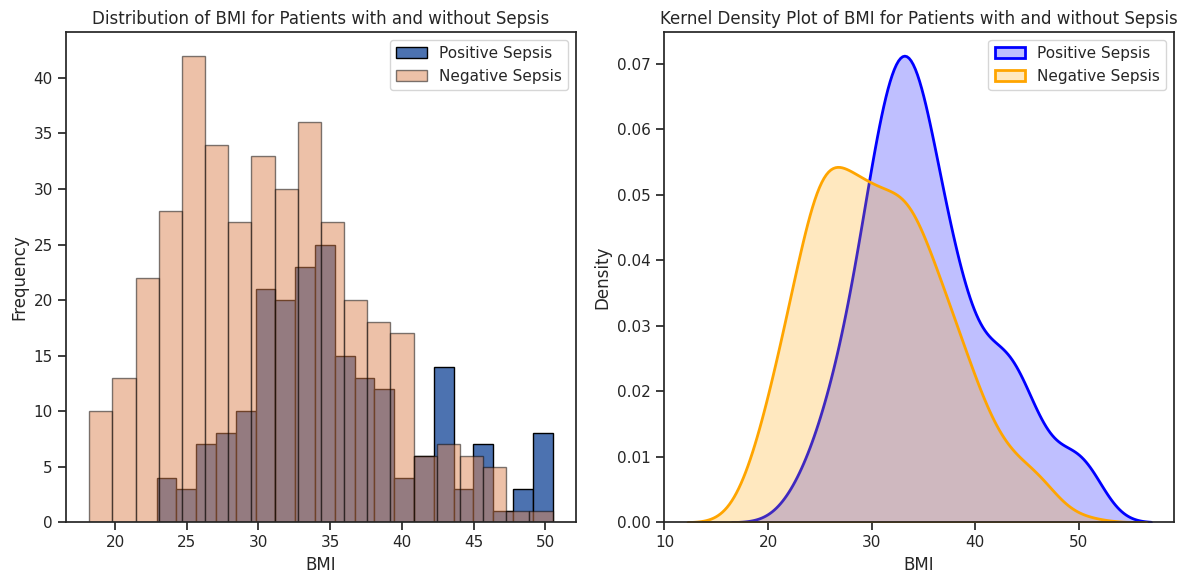

In [31]:
# Extract the 'BMI' column from the DataFrame
bmi_positive = positive_cases['BMI']
bmi_negative = negative_cases['BMI']

# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Distribution of BMI for Patients with and without Sepsis
axes[0].hist(bmi_positive, bins=20, edgecolor='black', label='Positive Sepsis')
axes[0].hist(bmi_negative, bins=20, edgecolor='black', alpha=0.5, label='Negative Sepsis')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of BMI for Patients with and without Sepsis')
axes[0].legend()

# Plot 2: Kernel Density Plot of BMI for Patients with and without Sepsis
sns.kdeplot(bmi_positive, shade=True, color='blue', linewidth=2, label='Positive Sepsis', ax=axes[1])
sns.kdeplot(bmi_negative, shade=True, color='orange', linewidth=2, label='Negative Sepsis', ax=axes[1])
axes[1].set_xlabel('BMI')
axes[1].set_ylabel('Density')
axes[1].set_title('Kernel Density Plot of BMI for Patients with and without Sepsis')
axes[1].legend()

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()


Patients with lower BMI are less likely to have sepsis

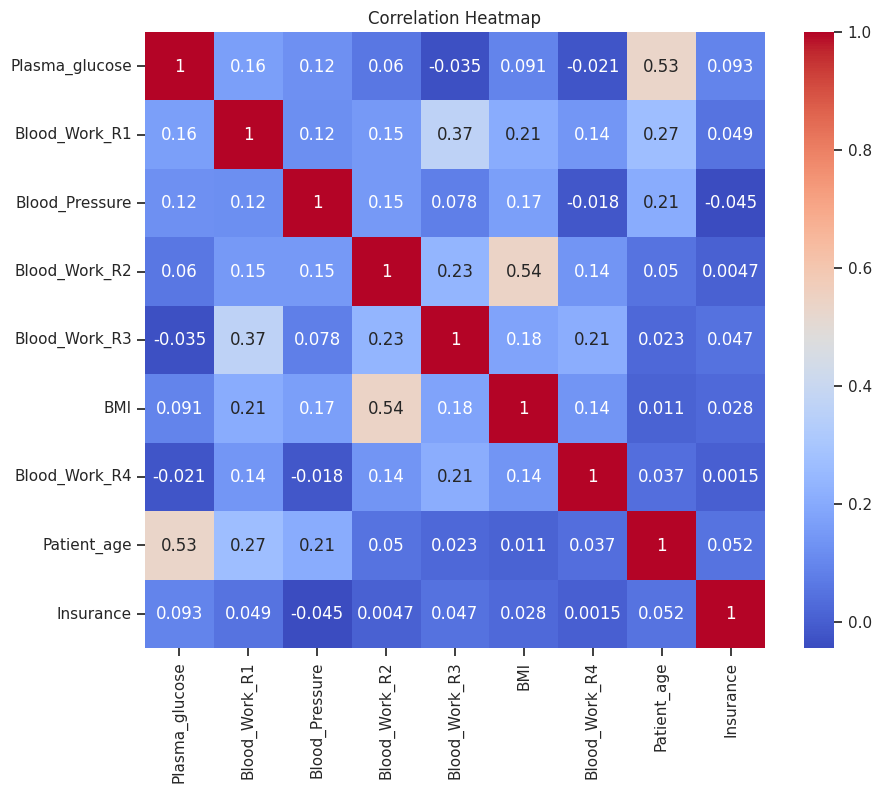

In [32]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sn.heatmap(num_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [33]:
# Calculate the correlation matrix
correlation_matrix = num_df.corr()

# Set the threshold for high correlation
threshold = 0.5

# Find the highly correlated variables
high_correlation = (correlation_matrix.abs() > threshold) & (correlation_matrix != 1)

# Get the variable pairs with high correlation
high_correlation_pairs = [(i, j) for i in high_correlation.columns for j in high_correlation.columns if high_correlation.loc[i, j]]

# Print the highly correlated variables
for pair in high_correlation_pairs:
    var1, var2 = pair
    correlation_value = correlation_matrix.loc[var1, var2]
    print(f"{var1} and {var2} are highly correlated (correlation value: {correlation_value})")

Plasma_glucose and Patient_age are highly correlated (correlation value: 0.5307618646199184)
Blood_Work_R2 and BMI are highly correlated (correlation value: 0.5420169830360818)
BMI and Blood_Work_R2 are highly correlated (correlation value: 0.5420169830360818)
Patient_age and Plasma_glucose are highly correlated (correlation value: 0.5307618646199184)


For each pair of columns that has a correlation of 0.5 and above,

We will later drop one column from each pair

While a correlation coefficient measures linear relationships, there might be non-linear relationships

between the variables that are not captured by the correlation coefficient alone.

Let's use scatter plot to explore this further

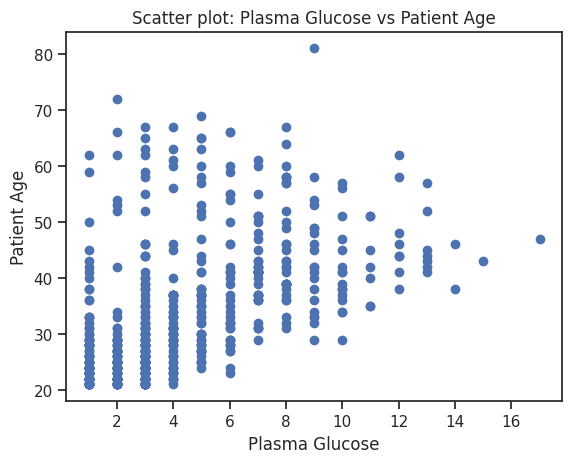

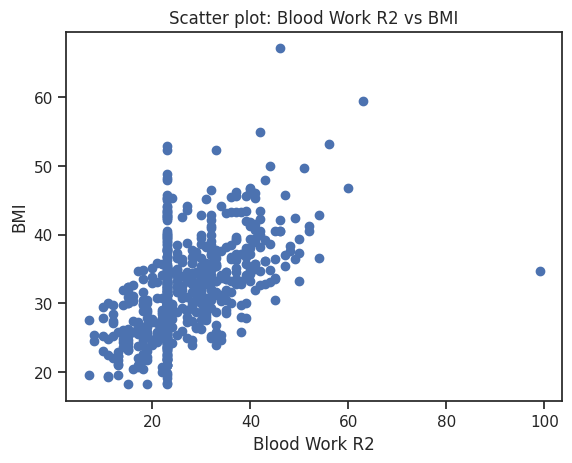

In [34]:
# Scatter plot: Plasma_glucose vs Patient_age
plt.scatter(num_df['Plasma_glucose'], num_df['Patient_age'])
plt.xlabel('Plasma Glucose')
plt.ylabel('Patient Age')
plt.title('Scatter plot: Plasma Glucose vs Patient Age')
plt.show()

# Scatter plot: Blood_Work_R2 vs BMI
plt.scatter(num_df['Blood_Work_R2'], num_df['BMI'])
plt.xlabel('Blood Work R2')
plt.ylabel('BMI')
plt.title('Scatter plot: Blood Work R2 vs BMI')
plt.show()

**OBSERVATION:**
The data points in Plasma_glucose and Patient_age are widely scattered, A tight cluster suggests a strong relationship, while a wide dispersion indicates a weak relationship or no relationship at all. So we will ignore this one.

The data points in Blood_Work_R2 and BMI are close together and have a linear positive relationship. So we will explore this further.

In [35]:
# Calculate the p-value for the correlation between Blood_Work_R2 and BMI
blood_work_r2 = num_df['Blood_Work_R2']
bmi = num_df['BMI']
corr, p_value = stats.pearsonr(blood_work_r2, bmi)
print("p-value (Blood_Work_R2 and BMI):", p_value)

p-value (Blood_Work_R2 and BMI): 2.3400759848855668e-46


In [36]:
# use spearman's test to confirm
corr2, p_value2 = stats.spearmanr(blood_work_r2, bmi)
print("p-value2 (Blood_Work_R2 and BMI):", p_value2)

p-value2 (Blood_Work_R2 and BMI): 2.1442057355491957e-53


**Observation:**
both p-values are significantly smaller than a typical significance level of 0.05

so there is a statistically significant correlation between Blood_Work_R2 and BMI.

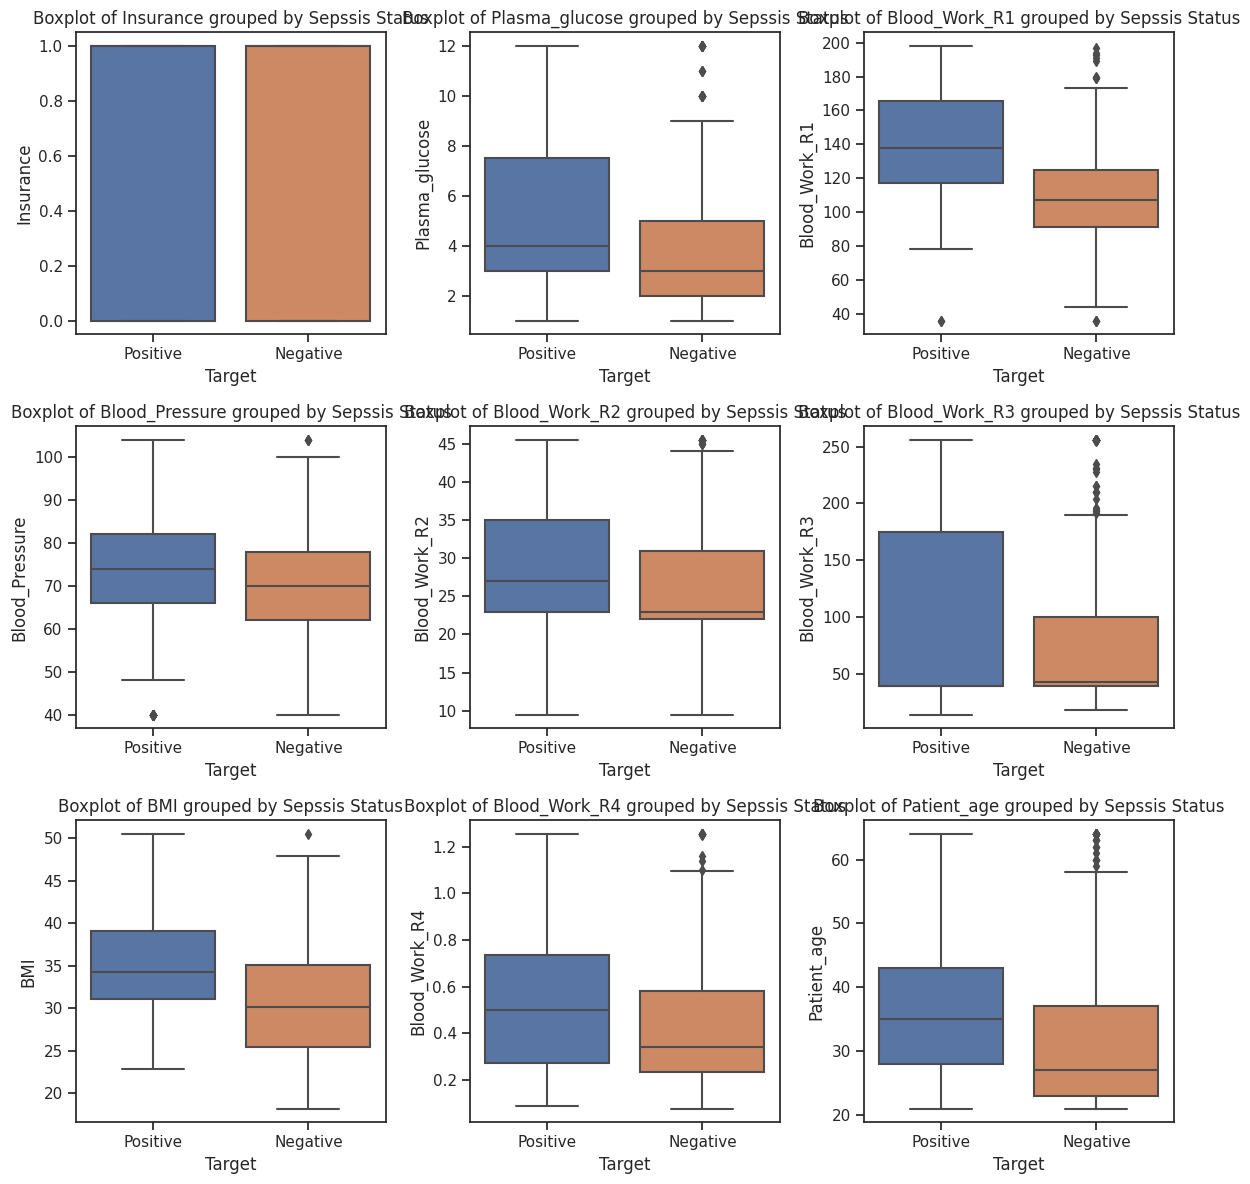

In [37]:
numeric_columns = ['Insurance', 'Plasma_glucose', 'Blood_Work_R1', 'Blood_Pressure', 'Blood_Work_R2', 'Blood_Work_R3', 'BMI', 'Blood_Work_R4', 'Patient_age']

# Define the layout grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Iterate over the numeric columns
for i, column in enumerate(numeric_columns):
    # Calculate the row and column indices in the grid
    row = i // 3
    col = i % 3

    # Create the boxplot
    sns.boxplot(x='Target', y=column, data=train_df, ax=axes[row, col])
    axes[row, col].set_title('Boxplot of ' + column + ' grouped by Sepssis Status')

# Adjust the layout and spacing
plt.tight_layout()

# Show the plots
plt.show()

Take a closer look at the insurance variable

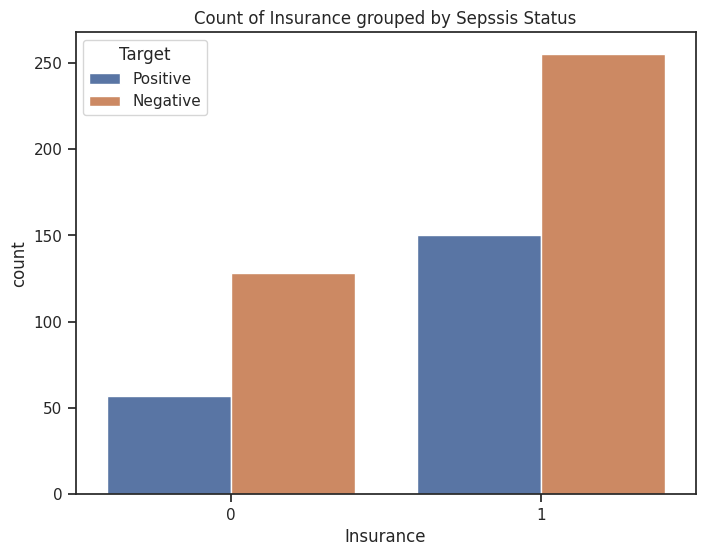

In [38]:
# Bar plots of categorical variable (Insurance) grouped by Sepssis Target
plt.figure(figsize=(8, 6))
sn.countplot(x='Insurance', hue='Target', data=train_df)
plt.title('Count of Insurance grouped by Sepssis Status')
plt.show()

**Observation:**
Insurance is irrelevant since it is Sepsis status doesn't change if you have insurance or not

so we will drop the insurance column later as well

# Hypothesis Validation

## What is P-value and t-statistic?

The p-value is like a "strength meter" for our data. It tells us how strong the evidence is against a particular idea. A small p-value means the evidence is strong and suggests that our idea is likely true, while a large p-value means the evidence is weak and our idea may not be true.

The t-statistic is like a "difference detector" between two groups. It measures how different the average values are between two groups and compares it to the variation within each group. A larger t-statistic means there is a bigger difference between the groups being compared.

In simpler terms, the p-value helps us decide if our idea is likely true or not, and the t-statistic tells us how big the difference is between two groups.

perform an independent samples t-test to compare the ages of patients with positive and negative Sepssis.

In [39]:
# Split the data into two groups based on the Sepssis variable
target_positive = train_df[train_df['Target'] == 'Positive']
target_negative= train_df[train_df['Target'] == 'Negative']

# Extract the Age(Patient_age) values for each group
age_target_positive = target_positive['Patient_age']
age_target_negative = target_negative['Patient_age']

# Perform independent samples t-test
t_statistic, p_value = ttest_ind(age_target_positive, age_target_negative)

# Print the results
print("P-Value:", p_value)
print("T-Statistic:", t_statistic)

P-Value: 3.4577022949183645e-07
T-Statistic: 5.1556614056454775


**Interpreting the results:**

A very small p-value of 3.4577022949183645e-07, we can conclude that there is a significant difference in the mean age between patients with and without Sepsis.

A large t-statistic of 5.1556614056454775 means there is a bigger difference between the groups being compared.

**_Null Hypothesis:_** Age does not determine whether a patient will develop Sepsis.

Null Hypothesis Rejected!

# Answers to Questions

1. Is the train dataset complete

In [40]:
train_df.isnull().sum()

ID                0
Plasma_glucose    0
Blood_Work_R1     0
Blood_Pressure    0
Blood_Work_R2     0
Blood_Work_R3     0
BMI               0
Blood_Work_R4     0
Patient_age       0
Insurance         0
Target            0
dtype: int64

There are no missing values in the dataset

2. What are the ages of the youngest and oldest patients

In [41]:
oldest_age = train_df['Patient_age'].max()
youngest_age= train_df['Patient_age'].min()

print(f'The youngest and oldest patients are {youngest_age} and {oldest_age} years respectively')

The youngest and oldest patients are 21 and 64 years respectively


3. What are the youngest and oldest patients with Sepssis?

In [42]:
highest_positive_age = positive_age_stats['max']
lowest_positive_age = positive_age_stats['min']

In [43]:
print(f'The youngest and oldest patient with Sepssis is {lowest_positive_age} and {highest_positive_age} years respectively')

The youngest and oldest patient with Sepssis is 21.0 and 64.0 years respectively


4. What is the average age ?

In [44]:
average_age = train_df['Patient_age'].mean()
print(f'The Average age is {average_age:.2f} years old')

The Average age is 33.32 years old


5. What is the ratio of patients who are positive for sepssis to the negative patients?

In [45]:
# Calculate the count of positive and negative patients
positive_count = train_df[train_df['Target'] == 'Positive'].shape[0]
negative_count = train_df[train_df['Target'] == 'Negative'].shape[0]

# Calculate the ratio
ratio = positive_count / negative_count

print(f'The ratio of patientrs positive for sepssis to negative patients is {ratio:.2f}')

The ratio of patientrs positive for sepssis to negative patients is 0.54


6.What is the highest and lowest BMI?

In [46]:
highest_bmi = train_df['BMI'].max()
lowest_bmi= train_df['BMI'].min()

print(f'The highest and lowest BMI is {highest_bmi:.2f} and {lowest_bmi:.2f} respectively')

The highest and lowest BMI is 50.51 and 18.20 respectively


7.What is the average BMI ?

In [47]:
average_bmi = train_df['BMI'].mean()

print(f'The average BMI is {average_bmi:.2f}')

The average BMI is 32.34


8. Is there a corelation between the Sepssis status and the other attributes?

In [48]:
# Replace "Positive" with 1 and "Negative" with 0
train_df['Target'] = train_df['Target'].replace({'Positive': 1, 'Negative': 0})

# Print the updated DataFrame
train_df.head(5)

,ID,Plasma_glucose,Blood_Work_R1,Blood_Pressure,Blood_Work_R2,Blood_Work_R3,BMI,Blood_Work_R4,Patient_age,Insurance,Target
0,ICU200010,6,148,72,35.0,39.0,33.6,0.627000,50,0,1
1,ICU200011,1,85,66,29.0,39.0,26.6,0.351000,31,0,0
2,ICU200012,8,183,64,23.0,39.0,23.3,0.672000,32,1,1
3,ICU200013,1,89,66,23.0,94.0,28.1,0.167000,21,1,0
4,ICU200014,3,137,40,35.0,168.0,43.1,1.253375,33,1,1


In [49]:
# Calculate the correlation between Sepssis status and other attributes
correlation_with_target = train_df.drop('ID', axis=1).corr()['Target'].drop('Target')

# Set the threshold for significant correlation
threshold = 0.3

# Find the attributes with significant correlation to Sepssis status
significant_correlation = correlation_with_target.abs() > threshold

# Get the attributes with significant correlation to Sepssis status
correlated_attributes = correlation_with_target[significant_correlation]

# Print the attributes with significant correlation to Sepssis status
for attribute, correlation_value in correlated_attributes.items():
    print(f"{attribute} has a moderate correlation with Sepssis status (correlation value: {correlation_value})")

Blood_Work_R1 has a moderate correlation with Sepssis status (correlation value: 0.4614006382433301)
BMI has a moderate correlation with Sepssis status (correlation value: 0.32856225936850497)


# Feature Processing and Engineering

Check and Drop Duplicates

In [50]:
#Check for duplicate rows in data
duplicate_rows = train_df.duplicated()
print("Number of duplicate rows:", duplicate_rows.sum())

Number of duplicate rows: 0


Impute Missing Values

In [51]:
missing_values = train_df.isna().sum()
print(missing_values)

ID                0
Plasma_glucose    0
Blood_Work_R1     0
Blood_Pressure    0
Blood_Work_R2     0
Blood_Work_R3     0
BMI               0
Blood_Work_R4     0
Patient_age       0
Insurance         0
Target            0
dtype: int64


# Drop Unnecessary Columns

We will remove Blood_work_R2 since it is also highly correlated to BMI

We will remove the ID column

we drop Insurance as well since it isnt a relevant field

In [52]:
train_df_new = train_df.drop(['Blood_Work_R2', 'ID', 'Insurance'], axis=1)

In [53]:
train_df_new

,Plasma_glucose,Blood_Work_R1,Blood_Pressure,Blood_Work_R3,BMI,Blood_Work_R4,Patient_age,Target
0,6,148,72,39.0,33.6,0.627000,50,1
1,1,85,66,39.0,26.6,0.351000,31,0
2,8,183,64,39.0,23.3,0.672000,32,1
3,1,89,66,94.0,28.1,0.167000,21,0
4,3,137,40,168.0,43.1,1.253375,33,1
...,...,...,...,...,...,...,...,...
594,6,123,72,230.0,33.6,0.733000,34,0
595,3,188,82,185.0,32.0,0.682000,22,1
596,3,67,76,39.0,45.3,0.194000,46,0
597,1,89,40,25.0,27.8,0.559000,21,0


# Data Spliting

In [54]:
# Use train_test_split with a random_state, and add stratify for Classification
# Split the  data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(train_df_new.iloc[:, :-1],
                                                    train_df_new.iloc[:, -1:],
                                                    test_size=0.2, random_state=42,
                                                    stratify=train_df_new.iloc[:, -1:])


In [55]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((472, 7), (118, 7), (472, 1), (118, 1))

In [56]:
X_train

,Plasma_glucose,Blood_Work_R1,Blood_Pressure,Blood_Work_R3,BMI,Blood_Work_R4,Patient_age
244,2,146,76,194.0,38.2000,0.329,29
5,5,116,74,39.0,25.6000,0.201,30
115,4,146,92,39.0,31.2000,0.539,61
123,5,132,80,39.0,26.8000,0.186,64
99,1,122,90,220.0,49.7000,0.325,31
...,...,...,...,...,...,...,...
125,1,88,40,99.0,50.5125,0.496,26
69,4,146,85,100.0,28.9000,0.189,27
112,1,89,76,37.0,31.2000,0.192,23
178,5,143,78,39.0,45.0000,0.190,47


In [57]:
y_train

,Target
244,0
5,0
115,1
123,0
99,1
...,...
125,1
69,0
112,0
178,0


# Data Imbalance Check

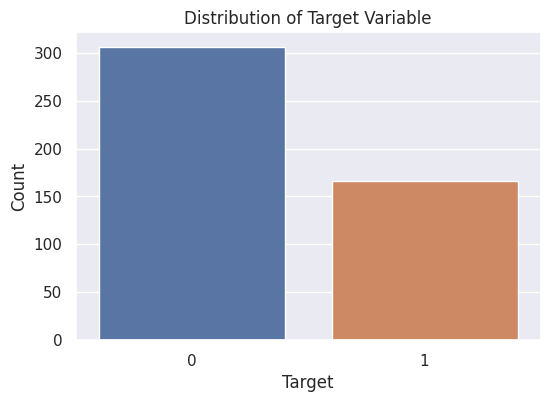

In [58]:
plt.figure(figsize=(6, 4))
sns.set(style="darkgrid")
sns.countplot(x='Target', data=y_train)

plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')

plt.show()

Dataset is imbalanced so we can't use Accuracy Score to choose our model

To solve this issue: we'll Oversample our minority class using RandomOverSampler

In [59]:
# Create a DataFrame to represent y_train
y_train_df = pd.DataFrame(y_train, columns=['Target'])

# Display the class distribution of the original y_train DataFrame
print("Original class distribution:")
print(y_train_df['Target'].value_counts())

# Perform random oversampling on the training data
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Create a DataFrame to represent the resampled y_train
y_train_resampled_df = pd.DataFrame(y_train_resampled, columns=['Target'])

# Display the class distribution of the resampled y_train DataFrame
print("\nResampled class distribution:")
print(y_train_resampled_df['Target'].value_counts())

# Assign the resampled data to X_train and y_train
X_train, y_train = X_train_resampled, y_train_resampled

Original class distribution:
0    306
1    166
Name: Target, dtype: int64

Resampled class distribution:
0    306
1    306
Name: Target, dtype: int64


# Feature Scaling

In [60]:
# Create an instance of StandardScaler and set output to be a DataFrame
scaler = StandardScaler().fit(X_train).set_output (transform="pandas")

# Scale the training data
X_train_df = scaler.transform(X_train)

# Scale the test data using the same scaler
X_test_df = scaler.transform(X_test)

# Machine Learning

Here is the section to build, train, evaluate and compare the models to each other.
1. Logistic Regression
2. RandomForest Classifier
3. XGBoost Classifier
4. K Nearest Neighbors
5. Support Vector Machines
6. DecisionTreeClassifier
7. Gradient Boosting Classifier Model

# 1. Logistic Regression

In [61]:
# Instanciate the model
lr = LogisticRegression(random_state=42)

In [62]:
# Train the model on the training set
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [63]:
# Predict on the test dataset
pred = lr.predict(X_test)
prob = lr.predict_proba(X_test)[:,1]

In [64]:
# model evaluation
r_lgt= recall_score(y_test, pred)
print("recall_score : ", r_lgt)

p_lgt= precision_score(y_test, pred)
print("precision_score :",p_lgt)

f1_lgt= f1_score(y_test, pred)
print("f1_score :", f1_lgt)

f2_lgt = fbeta_score(y_test, pred, beta=2, average='binary')
print("f2_score :", f2_lgt)

A_lgt= accuracy_score(pred, y_test)
print("accuracy_score :",A_lgt)

acu_lgt = roc_auc_score(pred, y_test)
print("ROC_AUC Score:",acu_lgt)

recall_score :  0.7560975609756098
precision_score : 0.62
f1_score : 0.6813186813186813
f2_score : 0.7242990654205608
accuracy_score : 0.7542372881355932
ROC_AUC Score: 0.7364705882352942


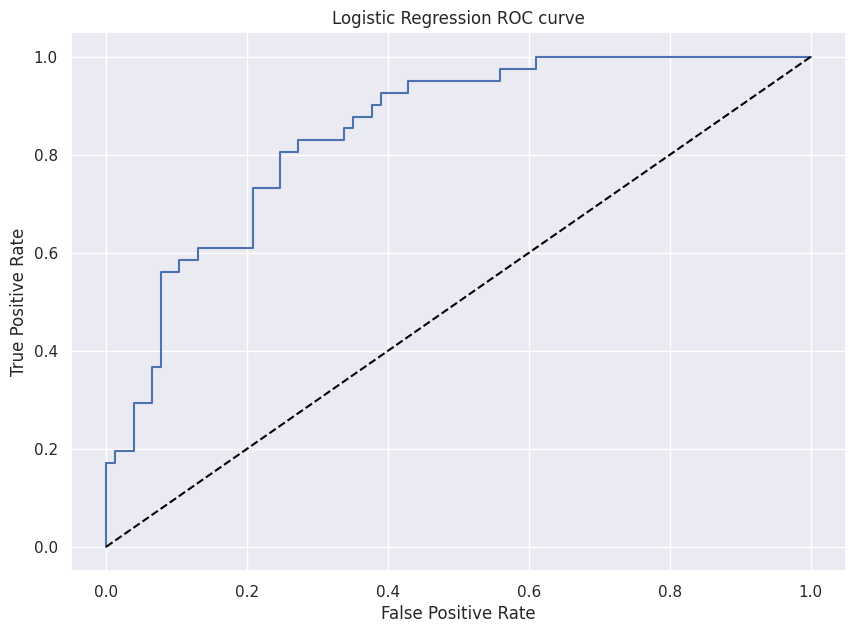

In [65]:
# plot the model evaluation
fpr, tpr, _ = roc_curve(y_test, prob)
fig, ax = plt.subplots(figsize=(10,7))
plt.title('Logistic Regression ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr,tpr)
plt.plot((0,1), linestyle="--",color='black')
plt.show()

# 2. RandomForest Classifier

In [66]:
# create the model
rf_model= RandomForestClassifier()

In [67]:
# train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [68]:
# Predict on the test dataset
rf_pred= rf_model.predict(X_test)
rf_proba= rf_model.predict_proba(X_test)[:,1]

In [69]:
# model evaluation
r_rf=  recall_score(y_test, rf_pred)
print("recall_score : ", r_rf)

p_rf= precision_score(y_test, rf_pred)
print("precision_score :",p_rf)

f1_rf= f1_score(y_test, rf_pred)
print("f1_score :", f1_rf)


f2_rf = fbeta_score(y_test, rf_pred, beta=2, average='binary')
print("f2_score :", f2_rf)

A_rf= accuracy_score(y_test, rf_pred)
print("accuracy_score :",A_rf)

acu_rf = roc_auc_score(rf_pred, y_test)
print("ROC_AUC Score:",acu_rf)

recall_score :  0.6829268292682927
precision_score : 0.6086956521739131
f1_score : 0.6436781609195402
f2_score : 0.6666666666666667
accuracy_score : 0.7372881355932204
ROC_AUC Score: 0.7140700483091788


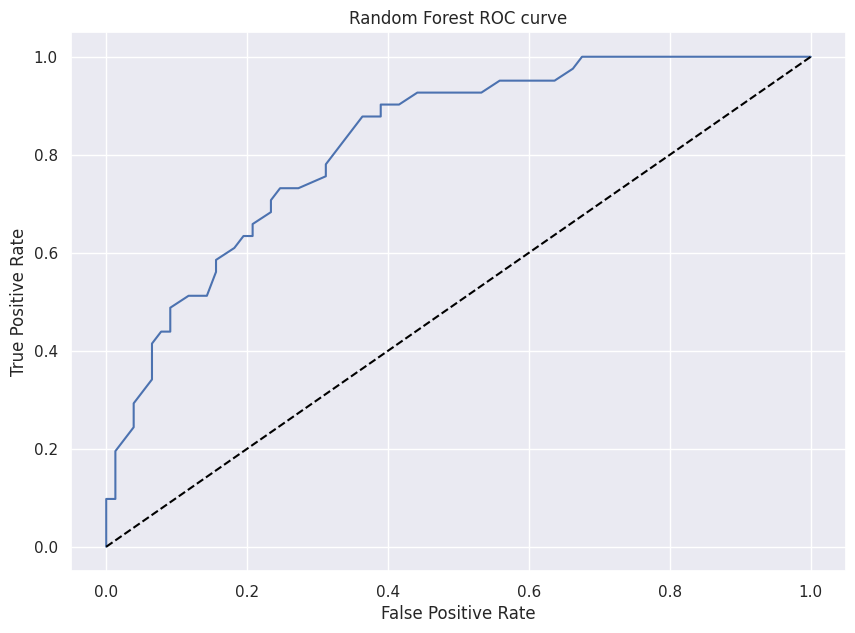

In [70]:
# plot the model evaluation
fig, ax = plt.subplots(figsize=(10,7))
fpr, tpr, _ = roc_curve(y_test, rf_proba)

plt.title('Random Forest ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr,tpr)
plt.plot((0,1), linestyle="--",color='black')
plt.show()

# 3. XGBoost Classifier

In [71]:
# create the model
xg_model= XGBClassifier()

In [72]:
# train the model
xg_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [73]:
# Predict on the test dataset
xg_pred = xg_model.predict(X_test)
xg_prob = xg_model.predict_proba(X_test)[:,1]

In [74]:
# model evaluation
r_xg= recall_score(y_test, xg_pred)
print("recall_score : ", r_xg)

p_xg= precision_score(y_test, xg_pred)
print("precision_score :",p_xg)

f1_xg= f1_score(y_test, xg_pred)
print("f1_score :", f1_xg)

f2_xg = fbeta_score(y_test, xg_pred, beta=2, average='binary')
print("f2_score :", f2_xg)


A_xg= accuracy_score( y_test, xg_pred)
print("accuracy_score :",A_xg)

acu_xg = roc_auc_score(xg_pred, y_test)
print("ROC_AUC Score:",acu_xg)


recall_score :  0.7804878048780488
precision_score : 0.6808510638297872
f1_score : 0.7272727272727273
f2_score : 0.7582938388625592
accuracy_score : 0.7966101694915254
ROC_AUC Score: 0.7770452502247527


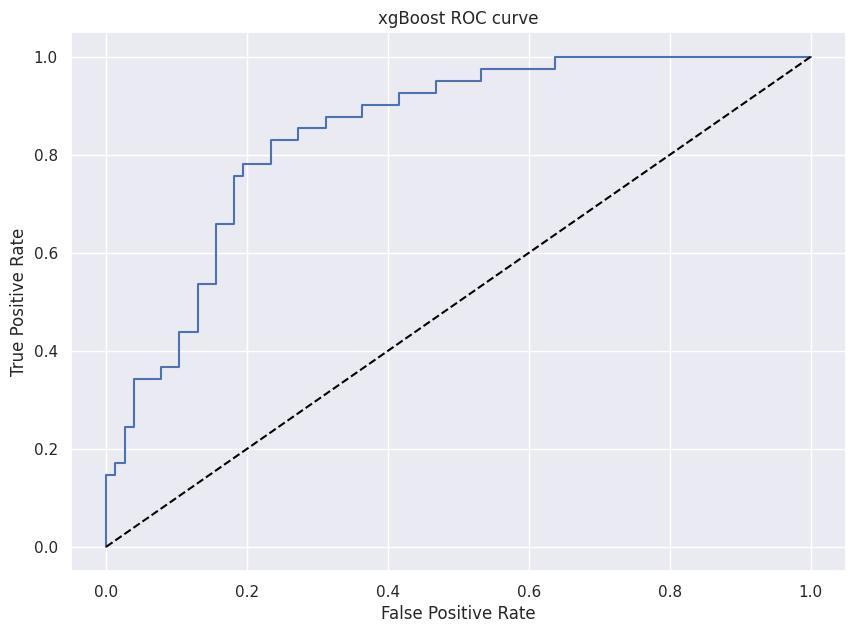

In [75]:
#  plot the model evaluation
fpr, tpr, _ = roc_curve(y_test, xg_prob)
fig, ax = plt.subplots(figsize=(10,7))
plt.title('xgBoost ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr,tpr)
plt.plot((0,1), linestyle="--",color='black')
plt.show()

# 4. K Nearest Neighbors

In [76]:
# create the model
knn_model = KNeighborsClassifier()

In [77]:
# train the model
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [78]:
# Predict on the test dataset
knn_pred = knn_model.predict(X_test)
knn_prob = knn_model.predict_proba(X_test)[:,1]

In [79]:
# model evaluation
r_knn= recall_score(y_test, knn_pred)
print("recall_score : ", r_knn)

p_knn= precision_score(y_test, knn_pred)
print("precision_score :",p_knn)

f1_knn= f1_score(y_test, knn_pred)
print("f1_score :", f1_knn)

f2_knn = fbeta_score(y_test, knn_pred, beta=2, average='binary')
print("f2_score :", f2_knn)


A_knn= accuracy_score( y_test, knn_pred)
print("accuracy_score :", A_knn)

acu_knn = roc_auc_score(knn_pred, y_test)
print("ROC_AUC Score:",acu_knn)

recall_score :  0.7073170731707317
precision_score : 0.5178571428571429
f1_score : 0.5979381443298969
f2_score : 0.6590909090909091
accuracy_score : 0.6694915254237288
ROC_AUC Score: 0.6621543778801843


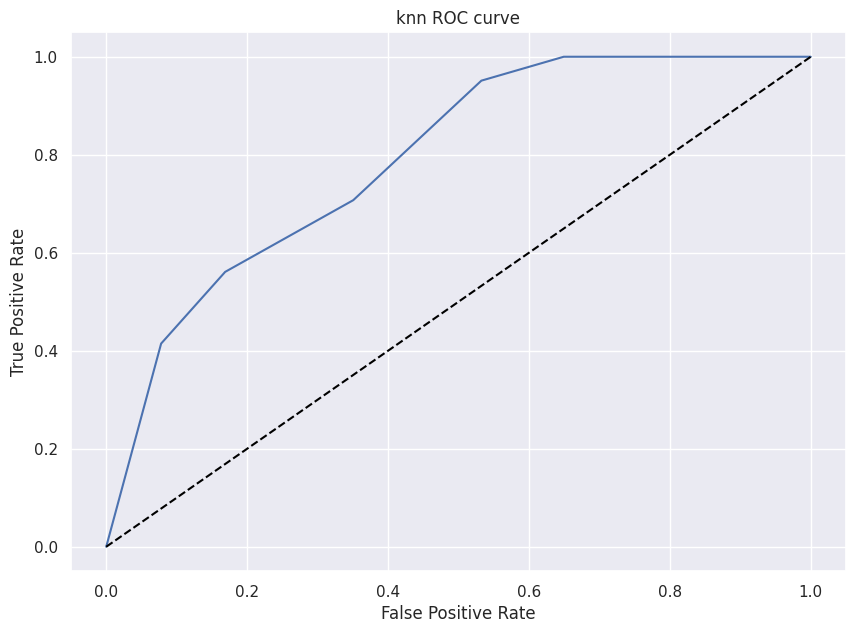

In [80]:
#  plot the model evaluation
fpr, tpr, _ = roc_curve(y_test, knn_prob)
fig, ax = plt.subplots(figsize=(10,7))
plt.title('knn ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr,tpr)
plt.plot((0,1), linestyle="--",color='black')
plt.show()

# 5. Support Vector Machines

In [81]:
# Create the Model
svc_model = SVC(kernel='rbf',
                C=51,
                gamma=1,
                probability=True)

In [82]:
# train the model
svc_model.fit(X_train, y_train)

SVC(C=51, gamma=1, probability=True)

In [83]:
# Predict on the test dataset
svc_pred = svc_model.predict(X_test)
svc_prob = svc_model.predict_proba(X_test)[:,1]

In [84]:
# model evaluation
r_svc = recall_score(y_test, svc_pred)
print("recall_score: ", r_svc)

p_svc = precision_score(y_test, svc_pred)
print("precision_score: ", p_svc)

f1_svc = f1_score(y_test, svc_pred)
print("f1_score: ", f1_svc)

f2_svc = fbeta_score(y_test, svc_pred, beta=2, average='binary')
print("f2_score: ", f2_svc)

A_svc = accuracy_score(y_test, svc_pred)
print("accuracy_score: ", A_svc)

# Check if both classes are present in y_test before calculating ROC AUC
if len(np.unique(y_test)) == 2:
    acu_svc = roc_auc_score(y_test, svc_pred)
    print("ROC_AUC Score: ", acu_svc)
else:
    print("Only one class present in y_test. ROC AUC score is not defined in that case.")

recall_score:  0.0
precision_score:  0.0
f1_score:  0.0
f2_score:  0.0
accuracy_score:  0.652542372881356
ROC_AUC Score:  0.5


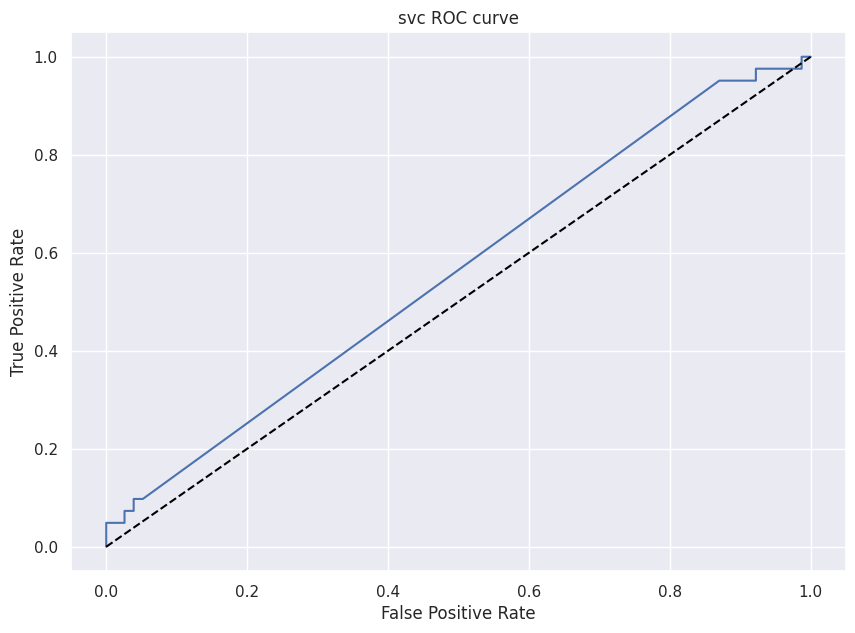

In [85]:
#  plot the model evaluation
fpr, tpr, _ = roc_curve(y_test, svc_prob)
fig, ax = plt.subplots(figsize=(10,7))
plt.title('svc ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr,tpr)
plt.plot((0,1), linestyle="--",color='black')
plt.show()

# 6. DecisionTreeClassifier

In [86]:
# create the model
dtmodel = DecisionTreeClassifier()

In [87]:
# train the model
dtmodel.fit(X_train, y_train)

DecisionTreeClassifier()

In [88]:
# Predict on the test dataset
dt_pred = dtmodel.predict(X_test)
dt_prob = dtmodel.predict_proba(X_test)[:,1]

In [89]:
# model evaluation
r_dt= recall_score(y_test, dt_pred)
print("recall_score : ", r_dt)

p_dt= precision_score(y_test, dt_pred)
print("precision_score :",p_dt)

f1_dt= f1_score(y_test, dt_pred)
print("f1_score :", f1_dt)

f2_dt = fbeta_score(y_test, dt_pred, beta=2, average='binary')
print("f2_score :", f2_dt)


A_dt= accuracy_score( y_test, dt_pred)
print("accuracy_score :", A_dt)

acu_dt = roc_auc_score(dt_pred, y_test)
print("ROC_AUC Score:",acu_dt)

recall_score :  0.5609756097560976
precision_score : 0.48936170212765956
f1_score : 0.5227272727272727
f2_score : 0.5450236966824644
accuracy_score : 0.6440677966101694
ROC_AUC Score: 0.6179202876835481


# 7. Gradient Boosting Classifier

In [90]:
# create the model
gbc = GradientBoostingClassifier(random_state=42)

In [91]:
# train the model
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [92]:
# Predict on the test dataset
gbc_pred = gbc.predict(X_test)
gbc_prob = gbc.predict_proba(X_test)[:,1]

In [93]:
# model evaluation
r_gbc= recall_score(y_test, gbc_pred)
print("recall_score : ", r_gbc)

p_gbc= precision_score(y_test, gbc_pred)
print("precision_score :",p_gbc)

f1_gbc= f1_score(y_test, gbc_pred)
print("f1_score :", f1_gbc)

f2_gbc = fbeta_score(y_test, gbc_pred, beta=2, average='binary')
print("f2_score :", f2_gbc)


A_gbc= accuracy_score( y_test, gbc_pred)
print("accuracy_score :", A_gbc)

acu_gbc = roc_auc_score(gbc_pred, y_test)
print("ROC_AUC Score:",acu_gbc)

recall_score :  0.7560975609756098
precision_score : 0.5961538461538461
f1_score : 0.6666666666666667
f2_score : 0.7175925925925926
accuracy_score : 0.7372881355932204
ROC_AUC Score: 0.7223193473193474


# Models comparison

In [94]:
compare_models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'K Nearest Neighbors', 'Support Vector Machines', 'Decision Tree', 'Gradient Boosting']

data = {'Accuracy': [A_lgt, A_rf, A_xg, A_knn, A_svc, A_dt, A_gbc],
        'Recall': [r_lgt, r_rf, r_xg, r_knn, r_svc, r_dt, r_gbc],
        'Precision': [p_lgt, p_rf, p_xg, p_knn, p_svc, p_dt, p_gbc],
        'F1 Score': [f1_lgt, f1_rf, f1_xg, f1_knn, f1_svc, f1_dt, f1_gbc],
        'F2 Score': [f2_lgt, f2_rf, f2_xg, f2_knn, f2_svc, f2_dt, f2_gbc],
        'ROC AUC': [acu_lgt, acu_rf, acu_xg, acu_knn, acu_svc, acu_dt, acu_gbc],
        'Description': ['' for _ in compare_models]}

result = pd.DataFrame(data=data, index=compare_models)
best_model = result['F1 Score'].idxmax()  # Get the index of the model with the highest F1 score
result.at[best_model, 'Description'] = 'Best Model'  # Update the description for the best model
result

,Accuracy,Recall,Precision,F1 Score,F2 Score,ROC AUC,Description
Logistic Regression,0.754237,0.756098,0.620000,0.681319,0.724299,0.736471,
Random Forest,0.737288,0.682927,0.608696,0.643678,0.666667,0.714070,
XGBoost,0.796610,0.780488,0.680851,0.727273,0.758294,0.777045,Best Model
K Nearest Neighbors,0.669492,0.707317,0.517857,0.597938,0.659091,0.662154,
Support Vector Machines,0.652542,0.000000,0.000000,0.000000,0.000000,0.500000,
Decision Tree,0.644068,0.560976,0.489362,0.522727,0.545024,0.617920,
Gradient Boosting,0.737288,0.756098,0.596154,0.666667,0.717593,0.722319,


# k-Fold cross validation

In [95]:
def kfold_cross_validation(model, model_name, X=X_train, y=y_train, n_splits=5, scoring='f1'):
    """
    Perform k-fold cross-validation for a given model and store the results in a DataFrame.

    Args:
        model: The model to be evaluated.
        model_name: The name of the model.
        X: The feature dataset.
        y: The target variable.
        n_splits: The number of folds for cross-validation.
        scoring: The scoring metric used for evaluation.
    """
    kf = KFold(n_splits=n_splits, shuffle=True)
    scores = cross_val_score(model, X, y, cv=kf, scoring=scoring, error_score="raise")
    cv_score_mean = scores.mean()
    cv_score_stdev = stdev(scores)

    global cross_validation_df
    cross_validation_df = cross_validation_df.append({'Model': model_name, 'F1 Score': cv_score_mean}, ignore_index=True)

In [96]:
# Create an empty DataFrame to store the results
cross_validation_df = pd.DataFrame(columns=['Model', 'F1 Score'])

# Repeat Cross Validation for all trained models

In [97]:
kfold_cross_validation(lr, 'Logistic Regression')
kfold_cross_validation(rf_model, 'Random Forest')
kfold_cross_validation(xg_model, 'XGBoost')
kfold_cross_validation(knn_model, 'K Nearest Neighbors')
kfold_cross_validation(svc_model, 'Support Vector Machines')
kfold_cross_validation(dtmodel, 'Decision Tree')
kfold_cross_validation(gbc, 'Gradient Boosting')

In [98]:
#  Select the best model based on the highest F1 score
best_model = cross_validation_df.loc[cross_validation_df['F1 Score'].idxmax()]
cross_validation_df.at[best_model.name, 'Best Model'] = True

# Print the updated DataFrame
print(cross_validation_df)

                     Model  F1 Score Best Model
0      Logistic Regression  0.706870        NaN
1            Random Forest  0.852398       True
2                  XGBoost  0.838086        NaN
3      K Nearest Neighbors  0.709619        NaN
4  Support Vector Machines  0.808638        NaN
5            Decision Tree  0.834946        NaN
6        Gradient Boosting  0.810718        NaN


# Hyperparameters tuning

# 2. RandomForest Classifier

In [99]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 15, stop = 80, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# maximum number of levels in tree
max_depth = [2,4,10, None]

# minimum number of samples required to split a node
min_samples_split = [2,5]

# minimum number of samples required at each leaf node
min_samples_leaf = [1,2]

# Method of selecting Samples for training each tree
bootstrap = [True]

In [100]:
# create param grid

param_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf,
              'bootstrap':bootstrap}
print(param_grid)

{'n_estimators': [15, 22, 29, 36, 43, 51, 58, 65, 72, 80], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [2, 4, 10, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True]}


In [101]:
# make GridSearchCV object
rf_Grid = GridSearchCV(estimator = rf_model,
                       param_grid = param_grid,
                       cv = 4,
                       verbose = 2 ,
                       n_jobs = -1,
                       scoring='f1',
                       refit=True)

In [102]:
# Fit the GridSearchCV object to the data
rf_Grid.fit(X_train,y_train)

Fitting 4 folds for each of 480 candidates, totalling 1920 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [2, 4, 10, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [15, 22, 29, 36, 43, 51, 58, 65, 72,
                                          80]},
             scoring='f1', verbose=2)

In [103]:
# Get the best estimator and its score
rf_tuned = rf_Grid.best_estimator_
rf_Grid.best_score_

0.8679770201088031

In [104]:
# Use the best estimator for predictions
y_pred_grid = rf_tuned.predict(X_test)
print(classification_report(y_pred_grid, y_test))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83        74
           1       0.73      0.68      0.71        44

    accuracy                           0.79       118
   macro avg       0.77      0.77      0.77       118
weighted avg       0.79      0.79      0.79       118



# 3. XGBoost Classifier (Best Model)

In [105]:
# Parameter grid for XGBC
xg_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7]
}

In [106]:
xg_Grid = GridSearchCV(
    estimator=gbc,
    param_grid=xg_param_grid,
    cv = 4,
    scoring='f1',
    refit=True
)

In [107]:
# Fit the GridSearchCV object to the data
xg_Grid.fit(X_train,y_train)

GridSearchCV(cv=4, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [108]:
# Get the best estimator and its score
xg_tuned = xg_Grid.best_estimator_
xg_Grid.best_score_

0.8660040755739681

In [109]:
# Use the best estimator for predictions
y_pred_grid = xg_tuned.predict(X_test)
print(classification_report(y_pred_grid, y_test))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76        75
           1       0.59      0.56      0.57        43

    accuracy                           0.69       118
   macro avg       0.67      0.67      0.67       118
weighted avg       0.69      0.69      0.69       118



In [110]:
with open('model.pkl', 'wb') as f:
    pickle.dump(xg_tuned, f)

In [111]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)